# Исследование поведения пользователей приложения по продаже продуктов питания

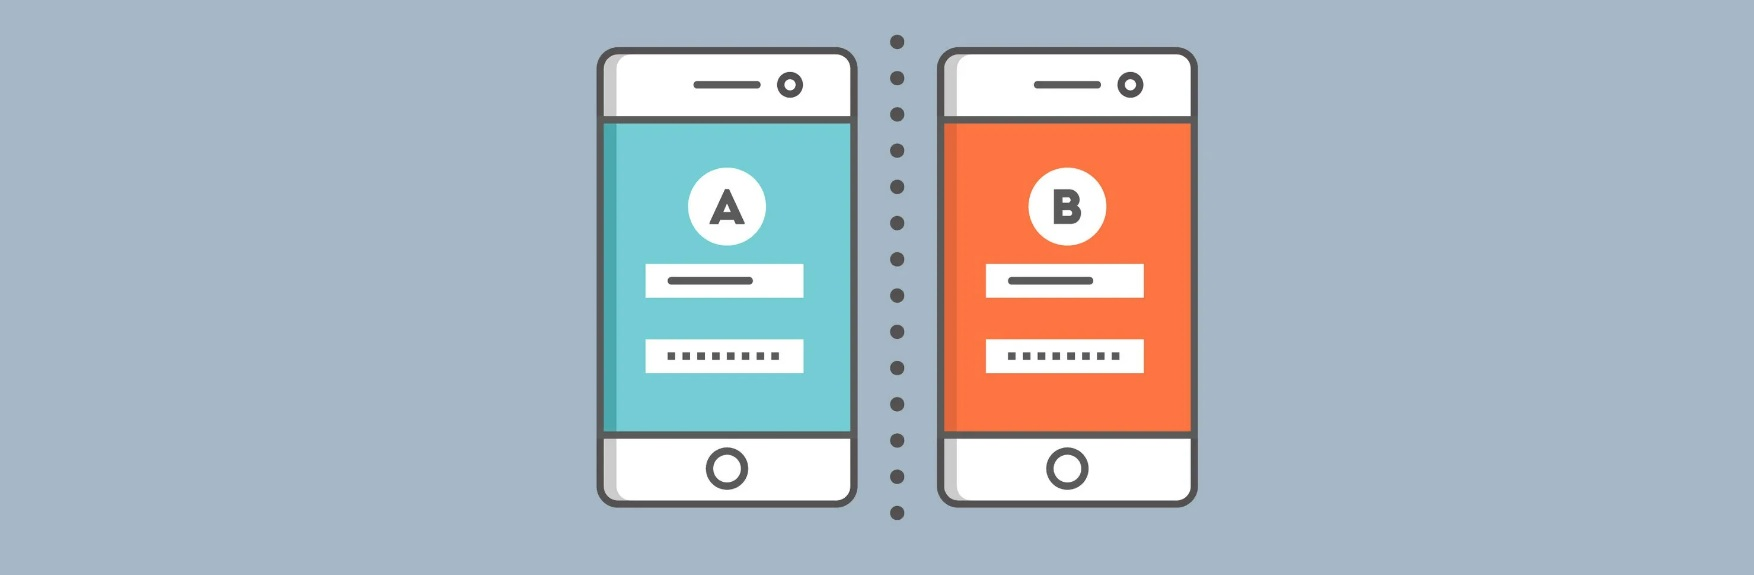

**Содержание** <a class='anchor' id='table_of_contents'></a>

* [Описание проекта](#description)
* [Описание данных](#data)
* [Шаг 1. Загрузка и изучение данных](#step_1)
* [Шаг 2. Предобработка данных](#step_2)
* [Шаг 3. Исследовательский анализ данных](#step_3)
* [Шаг 4. Анализ воронки событий](#step_4)
* [Шаг 5. Анализ результатов эксперимента](#step_5)
* [Шаг 6. Выводы](#final)

## Описание проекта <a class='anchor' id='description'></a>

В проекте исследуется стартап, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи мобильного приложения.

Изучив воронку продаж, необходимо узнать:
- как пользователи доходят до покупки;
- сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах;
- на каких именно шагах «застревают» пользователи.

После этого исследуются результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо выяснить, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, можно быть увереным в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

## Описание данных <a class='anchor' id='data'></a>

Каждая запись в логе — это действие пользователя, или событие.
- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Шаг 1. Загрузка и изучение данных <a class='anchor' id='step_1'></a>

Загрузим необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mth
import datetime
import plotly.express as px
from plotly import graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)

pd.set_option('mode.chained_assignment', None)

Загрузим необходимые для проекта функции.

In [2]:
# функция для подсчета дубликатов и получения общих сведений о датасете
def get_info(data):
    display(data.head())
    print()
    print('Число дубликатов:', data.duplicated().sum())
    print()
    data.info()

In [3]:
# функция для подсчета доли пропусков
def get_na(data):
    na_info = (
        pd.DataFrame(data.isna().mean())
        .rename(columns={0: 'NaN'})
        .style
        .set_caption('Доля пропусков')
        .background_gradient('coolwarm')
        .format('{:.2%}')
        )
    return na_info

Загрузим датасет проекта.

In [4]:
data = pd.read_csv('logs_exp.csv', sep='\t')

In [5]:
get_info(data)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248



Число дубликатов: 413

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


3 столбца датафрейма имеют целочисленный формат, столбец с названиями событий - строковый. В датафрейме выявлено наличие 413 дубликатов.

In [6]:
get_na(data)

,NaN
EventName,0.00%
DeviceIDHash,0.00%
EventTimestamp,0.00%
ExpId,0.00%


Пропуски в датасете не обнаружены.

[Назад к содержанию](#table_of_contents)

## Шаг 2. Предобработка данных <a class='anchor' id='step_2'></a>

Заменим названия столбцов на более удобные.

In [7]:
data = data.rename(columns={'EventName':'event_name',
                            'DeviceIDHash': 'user_id',
                            'EventTimestamp': 'event_timestamp',
                            'ExpId': 'exp_id'})
data.head()

,event_name,user_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Проверим датасет на наличие пропусков.

In [8]:
data.isna().sum()

event_name         0
user_id            0
event_timestamp    0
exp_id             0
dtype: int64

Пропусков не обнаружено. Проверим, имеются ли дубликаты.

In [9]:
print('Число дубликатов:', data.duplicated().sum())

Число дубликатов: 413


В датафрейме имеется существенное количество дубликатов - удалим эти строки. Возможно, их наличие связано со старыми логами, которые приходят из прошлых сессий пользователей.

In [10]:
data = data.drop_duplicates().reset_index(drop=True)

Добавим столбец `event_time` с датой и временем событий и отдельный столбец `session_date` с их датой. Приведем каждый из них в формат `datetime`.

In [11]:
data['event_time'] = pd.to_datetime(data['event_timestamp'], unit='s')
data['session_date'] = data['event_time'].dt.date
data['session_date'] = pd.to_datetime(data['session_date'])
data.head()

,event_name,user_id,event_timestamp,exp_id,event_time,session_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


[Назад к содержанию](#table_of_contents)

## Шаг 3. Исследовательский анализ данных <a class='anchor' id='step_3'></a>

Посмотрим, сколько всего событий в логе.

In [12]:
print('Событий в логе:', len(data))

Событий в логе: 243713


В датасете имеется 243 713 события. Посмотрим, сколько уникальных пользователей совершили эти события.

In [13]:
data['user_id'].nunique()

7551

В датасете 7 551 уникальных пользователей. Посмотрим, сколько в среднем приходится событий на одного пользователя.

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64


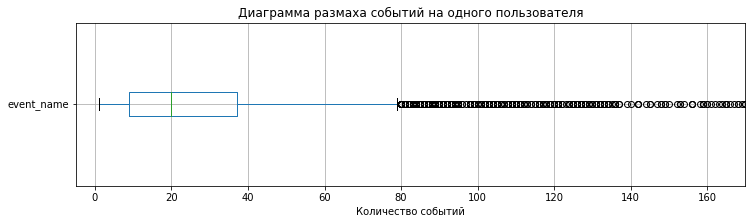

In [14]:
plt.figure(figsize=(12, 3))
data.groupby('user_id').agg({'event_name':'count'}).boxplot(vert=False)
plt.xlim(-5, 170)
plt.title('Диаграмма размаха событий на одного пользователя')
plt.xlabel('Количество событий');
print(data.groupby('user_id')['event_name'].count().describe())

В среднем каждый пользователь совершал около 32 действий, медианное значение - 20 действий на пользователя.

Найдем минимальную и максимальную дату датасета.

In [15]:
print('Минимальная дата:', data['event_time'].min())
print('Максимальная дата:', data['event_time'].max())
print('Всего дней:', data['event_time'].max() - data['event_time'].min())

Минимальная дата: 2019-07-25 04:43:36
Максимальная дата: 2019-08-07 21:15:17
Всего дней: 13 days 16:31:41


Датасет охватывает период с 25 июля 2019 г. по 7 августа 2019 г. (14 дней).

Посмотрим на распределение количества заказов.

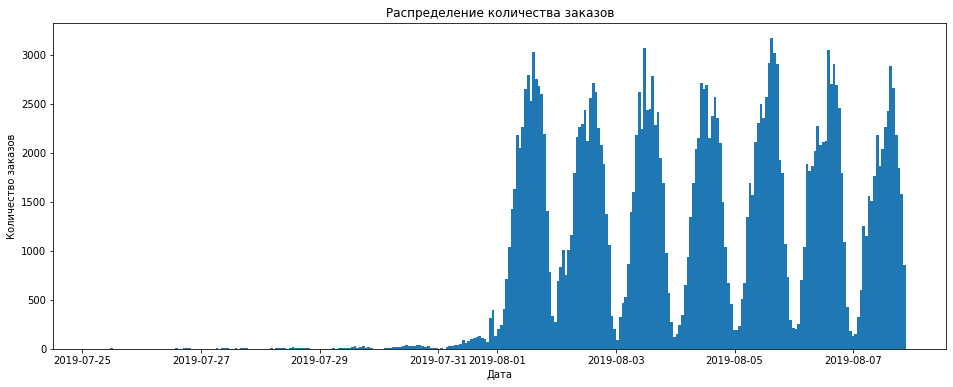

In [16]:
plt.figure(figsize=(16, 6))
plt.hist(data['event_time'], bins=300)
plt.title('Распределение количества заказов')
plt.xlabel('Дата')
plt.ylabel('Количество заказов');

Мы видим максимальные пики количества заказов в дневное время - в ночное время количество заказов спадает до минимальных значений. Хвост "старых" значений наблюдается до 1 августа 2019 г. - посмотрим более детально этот промежуток, чтобы определить момент начала эксперимента.

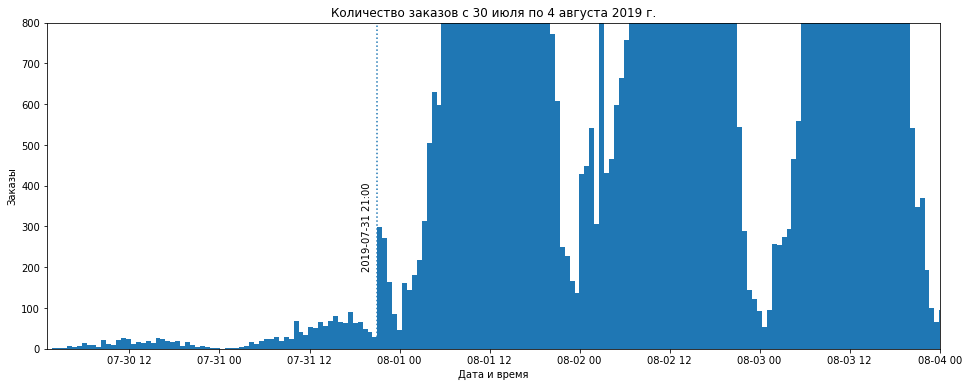

In [17]:
plt.figure(figsize=(16, 6))
plt.hist(data['event_time'], bins=500)
plt.xlim(left=data.loc[data['event_time'] >= '2019-07-30']['event_time'].min(), 
         right=data.loc[data['event_time'] >= '2019-08-04']['event_time'].min())
plt.ylim(top=800)
plt.vlines(x=datetime.datetime(2019, 7, 31, 21, 0), ymin=0, ymax=1000, linestyle='dotted')
plt.text(datetime.datetime(2019, 7, 31, 19, 0), 300, '2019-07-31 21:00', rotation=90, va='center')
plt.title('Количество заказов с 30 июля по 4 августа 2019 г.')
plt.xlabel('Дата и время')
plt.ylabel('Заказы');

Мы видим, что в 21:00 31 июля начинается резкий всплеск активности, сопоставимый с вечерними значениями дней эксперимента - установим это время в качестве начала эксперимента и отбросим все предыдущие данные до этого момента.

Посмотрим, сколько при этом может быть потеряно данных.

In [18]:
lost_events = len(data[data['event_time'] < '2019-07-31 21:00'])
lost_users = data['user_id'].nunique() - data[data['event_time'] >= '2019-07-31 21:00']['user_id'].nunique()

print(f"Событий будет удалено: {lost_events} из {len(data)} ({'{:.2%}'.format(lost_events / len(data))})")
print(f"Уникальных пользователей будет потеряно: {lost_users} из {data['user_id'].nunique()} ({'{:.2%}'.format(lost_users / data['user_id'].nunique())})")

Событий будет удалено: 1989 из 243713 (0.82%)
Уникальных пользователей будет потеряно: 13 из 7551 (0.17%)


При отсечении данных будет потеряно 0.82% событий, и лишь 0.17% пользователей, что не критично для дальнейшего анализа.

In [19]:
data = data[data['event_time'] >= '2019-07-31 21:00']

[Назад к содержанию](#table_of_contents)

## Шаг 4. Анализ воронки событий <a class='anchor' id='step_4'></a>

Посмотрим, какие события есть в логах и как часто они встречаются. Отсортируем события по частоте.

In [20]:
pd.DataFrame(data['event_name'].value_counts())

,event_name
MainScreenAppear,117889
OffersScreenAppear,46531
CartScreenAppear,42343
PaymentScreenSuccessful,33951
Tutorial,1010


В процессе покупки пользователи проходят через следующие шаги:
- `MainScreenAppear` - главный экран приложения;
- `OffersScreenAppear` - каталог с товарами;
- `CartScreenAppear` - корзина с покупками;
- `PaymentScreenSuccessful` - успешное завершение покупки;
- `Tutorial` - обучающий гид по приложению.

Наиболее частым событием является открытие пользователями главного экрана приложения.

Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей и посчитайте долю пользователей, которые хоть раз совершали событие.

In [21]:
all_events = (data
 .pivot_table(index='event_name', values='user_id', aggfunc=['count', 'nunique'])
 .rename(columns={'count':'total_events', 'nunique':'users'})
 .droplevel(1, axis=1)
 .reset_index()
)

total_users = pd.DataFrame(
    [['Total Users',
      all_events['total_events'].sum(),
      data['user_id'].nunique()]], 
    columns=['event_name','total_events','users'])

all_events = pd.concat([total_users, 
                        all_events.sort_values(by='users', 
                                               ascending=False)], 
                       ignore_index=True)

all_events['conversion'] = all_events['users'] / data['user_id'].nunique()

(all_events
 .style
 .format({'conversion':'{:.2%}'}))

,event_name,total_events,users,conversion
0,Total Users,241724,7538,100.00%
1,MainScreenAppear,117889,7423,98.47%
2,OffersScreenAppear,46531,4597,60.98%
3,CartScreenAppear,42343,3736,49.56%
4,PaymentScreenSuccessful,33951,3540,46.96%
5,Tutorial,1010,843,11.18%


Всего зафиксировано 7 538 человек в эксперименте. 98% из них заходили на главный экран приложения, 61% заходили в каталог, 50% доходило до корзины с товарами и около 47% успешно совершили покупку. Лишь 11% пользователей воспользовалось обучающими подсказками.

Построим воронку шагов, через которые проходят пользователи приложения в процессе покупки.

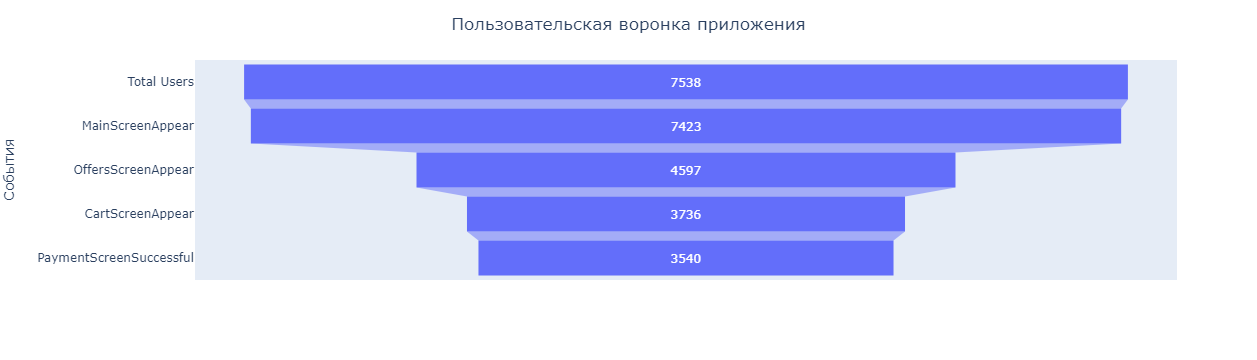

In [22]:
fig = px.funnel(all_events[all_events['event_name'] != 'Tutorial'], x='users', y='event_name')
fig.update_layout(title_text='Пользовательская воронка приложения', 
                  title_x=0.5,
                  yaxis_title='События')
fig.show()

Цепочка событий выстраивается следующим образом:
1. `MainScreenAppear` - главный экран приложения;
2. `OffersScreenAppear` - каталог с товарами;
3. `CartScreenAppear` - корзина с покупками;
4. `PaymentScreenSuccessful` - успешное завершение покупки;

Судя по малому количеству пользователей (843 чел.), шаг `Tutorial` не относится к событиям главной воронки и, вероятно, имеет необязательный характер. Поэтому не будем учитывать данный шаг в анализе - исключим эти события из датасета.

In [23]:
data = data[data['event_name'] != 'Tutorial']
all_events = all_events[all_events['event_name'] != 'Tutorial']

Расчитаем конверсию за шаг в столбце `conversion_per_step`.

In [24]:
all_events['conversion_per_step'] = all_events['users'] / all_events['users'].shift(1)
all_events.style.format({'conversion_per_step':'{:.2%}',
                         'conversion':'{:.2%}'}, na_rep='-')

,event_name,total_events,users,conversion,conversion_per_step
0,Total Users,241724,7538,100.00%,-
1,MainScreenAppear,117889,7423,98.47%,98.47%
2,OffersScreenAppear,46531,4597,60.98%,61.93%
3,CartScreenAppear,42343,3736,49.56%,81.27%
4,PaymentScreenSuccessful,33951,3540,46.96%,94.75%


Наибольшее число пользователей теряется при переходе с главного экрана в каталог товаров - переход осуществляет только 62%, т.е. потеря составляет 38% пользователей.

От входа в приложение и до завершения оплаты заказа доходит около 47% пользователей, что является относительно высоким показателем конверсии.

[Назад к содержанию](#table_of_contents)

## Шаг 5. Анализ результатов эксперимента <a class='anchor' id='step_5'></a>

Узнаем, сколько пользователей находится в каждой экспериментальной группе.

In [25]:
data.groupby('exp_id')['user_id'].nunique()

exp_id
246    2483
247    2516
248    2535
Name: user_id, dtype: int64

В целом, группы имеют равные пропорции, но не равны друг другу в абсолютном выражении. Максимальное различие наблюдается между группой 248 и 246 и составляет около 2%. В остальных случаях различие не превышает 1%.

Проверим корректность деления пользователей на группы.

In [26]:
print('Пересечений групп 246 и 247:', len(data[data['exp_id'] == 246]
                                          .merge(data[data['exp_id'] == 247], 
                                                 how='inner', 
                                                 on='user_id')))
print('Пересечений групп 246 и 248:', len(data[data['exp_id'] == 246]
                                          .merge(data[data['exp_id'] == 248], 
                                                 how='inner', 
                                                 on='user_id')))
print('Пересечений групп 247 и 248:', len(data[data['exp_id'] == 247]
                                          .merge(data[data['exp_id'] == 248], 
                                                 how='inner', 
                                                 on='user_id')))

Пересечений групп 246 и 247: 0
Пересечений групп 246 и 248: 0
Пересечений групп 247 и 248: 0


Группы эксперимента не смешиваются между собой, а значит, пользователи каждой группы уникальны и деление трафика происходит корректно.

Создадим датафрейм `groups`, в котором соберем данные об уникальных пользователях каждой группы.

In [27]:
groups = (pd.pivot_table(
    data, 
    index='event_name', 
    columns='exp_id', 
    values='user_id', 
    aggfunc='nunique')
.reset_index()
.sort_values(by=246, ascending=False))

total_groups = pd.DataFrame(
    [['Total Users',
      data[data['exp_id'] == 246]['user_id'].nunique(),
      data[data['exp_id'] == 247]['user_id'].nunique(),
      data[data['exp_id'] == 248]['user_id'].nunique()]], 
    columns=['event_name', 246, 247, 248])

groups = pd.concat([total_groups, groups], ignore_index=True)
groups

,event_name,246,247,248
0,Total Users,2483,2516,2535
1,MainScreenAppear,2450,2479,2494
2,OffersScreenAppear,1542,1524,1531
3,CartScreenAppear,1266,1239,1231
4,PaymentScreenSuccessful,1200,1158,1182


На основе датафрейма `groups` построим график воронки с разбивкой по группам.

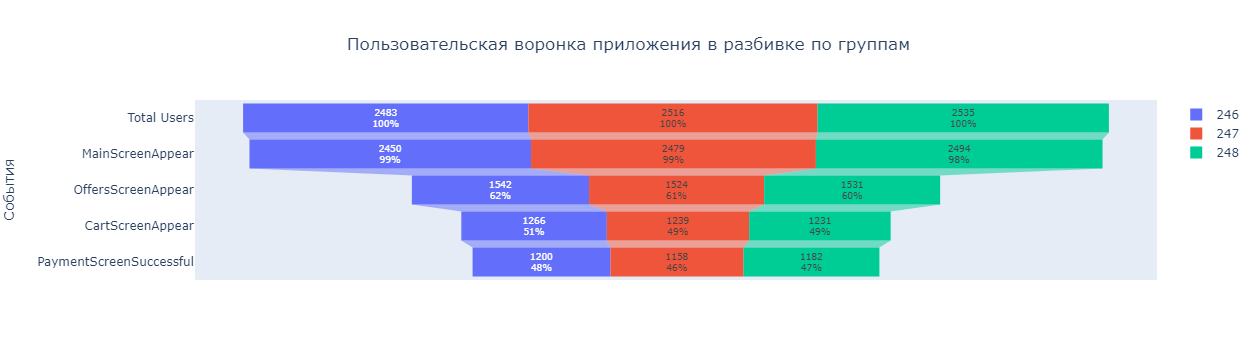

In [28]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = '246',
    y = groups['event_name'],
    x = groups[246],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = '247',
    orientation = "h",
    y = groups['event_name'],
    x = groups[247],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = '248',
    orientation = "h",
    y = groups['event_name'],
    x = groups[248],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.update_layout(title_text='Пользовательская воронка приложения в разбивке по группам', 
                  title_x=0.5,
                  yaxis_title='События')

fig.show()

Все три группы эксперимента имеют равные доли пользователей на каждом этапе воронки - различия не превышают 1-2%. Проверим, имеют ли данные различия статистическую значимость или же они случайны.

Чтобы проверить корректность всех механизмов и расчётов, проведем A/A-тест - между выборками 246 и 247.

Объявим функцию `z_test`, которая в качестве аргументов будет принимать номера групп эксперимента и название события. За уровень значимости по умолчанию будет отвечать аргумент `alpha=0.05`. Расчеты в теле функции будут основываться на датафрейме `groups`, в котором агрегированы данные в разбивке по каждой группе.

In [29]:
def z_test(group_1, group_2, event_name, alpha=0.05):
    
    successes = np.array([
        int(groups[group_1][groups['event_name'] == event_name]),   
        int(groups[group_2][groups['event_name'] == event_name])   
    ])

    trials = np.array([
        int(groups[group_1][groups['event_name'] == 'Total Users']),
        int(groups[group_2][groups['event_name'] == 'Total Users'])
    ])

    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]

    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('Событие:', event_name)
    print(f'Доля группы {group_1}: {"{:.2%}".format(p1)}')
    print(f'Доля группы {group_2}: {"{:.2%}".format(p2)}')
    print('Разница:', "{:.2%}".format(difference))
    print('Уровень значимости:', alpha)
    print('p-value: ', '{:.4}'.format(p_value))

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    print()

Поскольку будет проводиться множественная проверка гипотез, во избежание увеличения вероятности совершить ошибку I рода (ложнопозитивный результат) необходимо скорректировать уровень значимости. Воспользуемся поправкой Бонферрони - разделим уровень значимости на количество проводимых попарных сравнений.

<p>Введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Доли уникальных посетителей, побывавших на этапе воронки, одинаковы.}\\
   H_1 :\text{Между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница.}
 \end{cases}
\end{equation*}$

In [30]:
events = ['MainScreenAppear', 
          'OffersScreenAppear', 
          'CartScreenAppear', 
          'PaymentScreenSuccessful']

m = len(events)

for event in events: 
    z_test(246, 247, event, alpha=0.05 / m)

Событие: MainScreenAppear
Доля группы 246: 98.67%
Доля группы 247: 98.53%
Разница: 0.14%
Уровень значимости: 0.0125
p-value:  0.6702
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
Доля группы 246: 62.10%
Доля группы 247: 60.57%
Разница: 1.53%
Уровень значимости: 0.0125
p-value:  0.2667
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
Доля группы 246: 50.99%
Доля группы 247: 49.24%
Разница: 1.74%
Уровень значимости: 0.0125
p-value:  0.2181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
Доля группы 246: 48.33%
Доля группы 247: 46.03%
Разница: 2.30%
Уровень значимости: 0.0125
p-value:  0.1029
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Ни в одном из проведенных тестов не удалось отвергнуть нулевую гипотезу, а значит группы 246 и 247 не имеют между собой статистически значимых различий. При верности нулевой гипотезы различия между ними получены случайно.

Учитывая отсутствие статистической значимости между контрольными группами, можно утверждать, что разбивка на группы была проведена корректно.

Далее, сравним результаты тестовой группы с каждой из контрольных в отдельности по каждому событию.

Объединим контрольные группы в столбце `246+247`.

In [31]:
groups['246+247'] = groups[246] + groups[247]
groups

,event_name,246,247,248,246+247
0,Total Users,2483,2516,2535,4999
1,MainScreenAppear,2450,2479,2494,4929
2,OffersScreenAppear,1542,1524,1531,3066
3,CartScreenAppear,1266,1239,1231,2505
4,PaymentScreenSuccessful,1200,1158,1182,2358


<p>Введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Доли уникальных посетителей, побывавших на этапе воронки, одинаковы.}\\
   H_1 :\text{Между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница.}
 \end{cases}
\end{equation*}$

In [32]:
# попарные сравнения групп
pairs = [(246, 247),
         (246, 248),
         (247, 248),
         ('246+247', 248)]

# исследуемые события воронки
events = ['MainScreenAppear', 
          'OffersScreenAppear', 
          'CartScreenAppear', 
          'PaymentScreenSuccessful']

# число попарных сравнений (m = 16)
m = len(pairs) * len(events)

# исходный уровень значимости
alpha = 0.05

# поправка Бонферрони
bonferroni_alpha = alpha / m

for pair in pairs:
    print('Сравниваемые группы:', pair)
    print()
    for event in events:
        z_test(pair[0], pair[1], event, alpha=bonferroni_alpha)
    print('-------------------------------')

Сравниваемые группы: (246, 247)

Событие: MainScreenAppear
Доля группы 246: 98.67%
Доля группы 247: 98.53%
Разница: 0.14%
Уровень значимости: 0.003125
p-value:  0.6702
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
Доля группы 246: 62.10%
Доля группы 247: 60.57%
Разница: 1.53%
Уровень значимости: 0.003125
p-value:  0.2667
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
Доля группы 246: 50.99%
Доля группы 247: 49.24%
Разница: 1.74%
Уровень значимости: 0.003125
p-value:  0.2181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
Доля группы 246: 48.33%
Доля группы 247: 46.03%
Разница: 2.30%
Уровень значимости: 0.003125
p-value:  0.1029
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

-------------------------------
Сравниваемые группы: (246, 248)

Событие: MainScreenAppear
Доля группы

Статистические тесты показали следующие результаты:
- 246 и 247 - нет оснований считать доли разными;
- 246 и 248 - нет оснований считать доли разными;
- 247 и 248 - нет оснований считать доли разными;
- объединенные контрольные группы и 248 - нет оснований считать доли разными.

Как видно из тестов, во всех попарных сравнениях группы имели существенные относительные различия (до 2.43%), выраженные в процентах, однако, они не имеют статистической значимости и могли быть получены случайно.

Если в ходе эксперимента принимается решение изменить уровень значимости, подобное вмешательство порождает так называемую проблему подглядывания, которая может исказить результаты в сторону субъективно желаемых. В данном исследовании изменение уровня значимости не имеет смысла, поскольку в процессе множественной проверки гипотез необходим как можно более низкий уровень значимости, снижающий вероятность ошибки. В противном случае вновь растет вероятность получить ложнопозитивный результат (найти различие, когда его нет на самом деле).

Тем не менее, для наглядности проведем статистические тесты с исходным уровнем `alpha = 0.10`.

<p>Введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Доли уникальных посетителей, побывавших на этапе воронки, одинаковы.}\\
   H_1 :\text{Между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница.}
 \end{cases}
\end{equation*}$

In [33]:
# попарные сравнения групп
pairs = [(246, 247),
         (246, 248),
         (247, 248),
         ('246+247', 248)]

# исследуемые события воронки
events = ['MainScreenAppear', 
          'OffersScreenAppear', 
          'CartScreenAppear', 
          'PaymentScreenSuccessful']

# число попарных сравнений (m = 16)
m = len(pairs) * len(events)

# исходный уровень значимости
alpha = 0.10

# поправка Бонферрони
bonferroni_alpha = alpha / m

for pair in pairs:
    print('Сравниваемые группы:', pair)
    print()
    for event in events:
        z_test(pair[0], pair[1], event, alpha=bonferroni_alpha)
    print('-------------------------------')

Сравниваемые группы: (246, 247)

Событие: MainScreenAppear
Доля группы 246: 98.67%
Доля группы 247: 98.53%
Разница: 0.14%
Уровень значимости: 0.00625
p-value:  0.6702
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
Доля группы 246: 62.10%
Доля группы 247: 60.57%
Разница: 1.53%
Уровень значимости: 0.00625
p-value:  0.2667
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
Доля группы 246: 50.99%
Доля группы 247: 49.24%
Разница: 1.74%
Уровень значимости: 0.00625
p-value:  0.2181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
Доля группы 246: 48.33%
Доля группы 247: 46.03%
Разница: 2.30%
Уровень значимости: 0.00625
p-value:  0.1029
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

-------------------------------
Сравниваемые группы: (246, 248)

Событие: MainScreenAppear
Доля группы 246

Повышение уровня значимости до 0.10 с применением поправки Бонферрони (16 попарных сравнений) также не выявляют статистически значимых различий между всеми группами и событиями.

В связи вышеперечисленными выводами, следует остановить A/A/B-тест и признать, что нововведение по изменению шрифта в приложении для тестовой группы 248 __никак не повлияло__ на конверсию пользователей.

[Назад к содержанию](#table_of_contents)

## Шаг 6. Выводы <a class='anchor' id='final'></a>

По итогам проведенного исследования можно утверждать следующее:

- всего зафиксировано 7 538 человек в эксперименте: 98% из них заходили на главный экран приложения, 61% заходили в каталог, 50% доходило до корзины с товарами и около 47% успешно совершили покупку. Лишь 11% пользователей воспользовалось обучающими подсказками;
- наиболее частым событием является открытие пользователями главного экрана приложения;
- наибольшее число пользователей теряется при переходе с главного экрана в каталог товаров - переход осуществляет только 62%, т.е. потеря составляет 38% пользователей;
- от входа в приложение и до завершения оплаты заказа доходит около 47% пользователей, что является относительно высоким показателем конверсии;
- группы эксперимента не смешиваются между собой, а значит, пользователи каждой группы уникальны и деление трафика происходит корректно;
- все три группы эксперимента имеют равные доли пользователей на каждом этапе воронки - различия не превышают 1-2%;
- учитывая отсутствие статистической значимости между контрольными группами, можно утверждать, что разбивка на группы была проведена корректно;
- во всех попарных сравнениях группы имели существенные относительные различия (до 2.43%), выраженные в процентах, однако, они не имеют статистической значимости при исходном уровне значимости 0.05 с поправкой Бонферрони (16 попарных сравнений) и могли быть получены случайно;
- повышение уровня значимости до 0.10 с применением поправки Бонферрони (16 попарных сравнений) также не выявляют статистически значимых различий между всеми группами и событиями;
- нововведение по изменению шрифта в приложении для тестовой группы 248 никак не повлияло на конверсию пользователей.

[Назад к содержанию](#table_of_contents)